In [1]:
import torch
from torch.autograd import Variable
from functorch import vmap
import matplotlib.pylab as plt
import numpy as np
import scipy.stats as ss

import random

In [2]:
import sys
sys.path.insert(0,'vp_class/')

In [3]:
from class_ou import OU, ou_gradient
from class_vp_tou import tOU, tOU_Score

This code applies variational inference based on time-dependent OU processes to the observations drawn from time-homogeneous OU process, as defined below. Note that we have chosen observational noise, i.e. variance of Gaussian noise and SDE variance to be 0.04 and 0.8 repectively. While the former is equal to the paramterization considered in Archambeau et al 2007, the latter is higher (0.8 vs 0.5)

Noisy Observations from the SDE:

$dX_{t} = -X_{t}dt + \sigma dW_{t}$

In [4]:
alpha = torch.tensor([0.]).repeat(1, 1)
beta = torch.tensor([1.]).repeat(1, 1)
z0 = torch.tensor([10.]).repeat(1,1)
sde_sigma = 1.

In [5]:
true_sde = OU(t0 = 0, t1 = 8., z0 = z0, alpha = alpha, beta = beta, sigma = torch.tensor(sde_sigma).repeat(1,1), dN=801, timegrid='True')

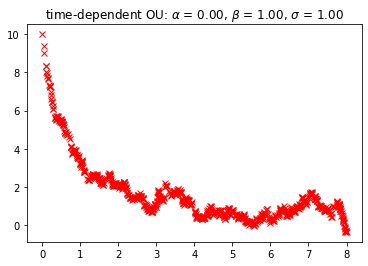

In [6]:
plt.plot(true_sde.pts.T, true_sde.trj.T, 'rx')
plt.title(r"time-dependent OU: $\alpha$ = %.2f" % true_sde.alpha + r", $\beta$ = %.2f" % true_sde.beta + r", $\sigma$ = %.2f" % true_sde.sigma)
plt.show()

In [7]:
obs_sigma = 0.04
obs = torch.from_numpy(np.random.normal(loc = true_sde.trj[0][::100], scale = obs_sigma)).reshape(-1, 1)
obs_time = true_sde.pts[0][::100]

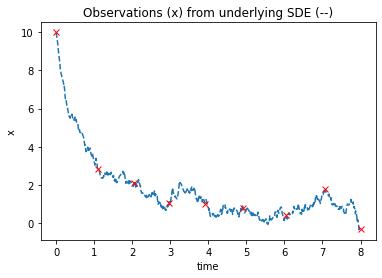

In [8]:
plt.title("Observations (x) from underlying SDE (--)")
plt.plot(true_sde.pts.T, true_sde.trj.T, '--')
plt.plot(true_sde.pts[0][::100], obs, 'rx')
plt.xlabel("time")
plt.ylabel("x")
plt.show()

**Class: OU processes**

Variational inference: KL

In [9]:
class ELBO:

    """
        Given a simulated variational process, compute the gradient of the ELBO. 
    """
    def __init__(self, ou):
        self.ou = ou
        self.alpha = ou.alpha
        self.beta = ou.beta
        self.sigma = torch.tensor(ou.sigma)
        self.r = ou.r
        self.m0 = ou.m0
        
    def KL_ito(self):
        """
            1. Compute the Riemann approximation to integral in KL divergence
            
        """
        # Save parameter specification from ou class
        alpha, beta, sigma, r, m0 = self.alpha, self.beta, self.sigma, self.r, self.m0
        
        def B(s, beta):
            return (s+1) ** beta
        
        # Obtain integral term (via Riemann approximation, e.g. trapezoid)
        func = lambda s, z: -0.5 * (1-(r**2)) * z ** 2 + alpha * beta * (B(s, beta-1) + 1) * z \
                    -0.5 * ((r**2) - 1) * (alpha**2) * (beta**2) * B(s, 2*(beta-1)) \
                    -0.5 * (alpha * (B(s, beta) - 1) + m0 + r * alpha * beta * B(s, beta-1)) \
                    * (2 * z - alpha * (B(s, beta) - 1) - m0 - r * alpha * beta *B(s, beta - 1))
        
        num = func(self.ou.pts, self.ou.trj)

        return torch.trapezoid(num, x=self.ou.pts).reshape(-1, 1)
    
    def KL_rest(self):
        """
            2. Compute the rest
        """

        alpha, beta, sigma, r, m0 = self.alpha, self.beta, self.sigma, self.r, self.m0
        D = self.ou.D
        
        z0 = self.ou.z0

        z1 = self.ou.trj[:, -1].reshape(D, 1)
        t0 = self.ou.t0.clone().detach().repeat(D, 1)
        t1 = self.ou.t1.clone().detach().repeat(D, 1)
        # Obtain the rest 
        def A(s, u):
            return (r - 1) * 0.5 * (u ** 2) - u * r * alpha * (((s+1) ** beta) - 1) - r * m0 * u - alpha * beta * (s+1) * u
            
        return A(t1, z1) - A(t0, z0) - 0.5 * (r - 1) * (t1 - t0)
    
    def log_prob(self, obs, obs_sigma):
        """
            Compute the log-likelihood
            likelihood function is normal density N(obs, var)
            obs.shape = D * 1 (D: # of sample)
        """
        def log_pdf(obs, z, obs_sigma):
            return ss.norm.logpdf(obs, loc=z, scale=obs_sigma)
            
        return torch.from_numpy(log_pdf(obs, self.ou.trj[:, -1].reshape(-1, 1), obs_sigma))


**Variational inference: a piece-wise approximation**

In [10]:
import tqdm as tq

In [11]:
D = 200
S = 50
learning_rate = 0.00005
lr = learning_rate
IT = 200
dN = 30
z0 = obs[0]

# Linear mean function
beta_D = torch.tensor([1.]).repeat(D, 1)

vp_mean = []
vp_std = []
vp_pts = []

elbo_traces = np.empty((len(obs_time) - 1, IT-1))
KL_traces = np.empty((len(obs_time) -1 , IT-1))
NLL_traces = np.empty((len(obs_time) -1 , IT-1))
pars_traces = np.empty((3, len(obs_time) - 1, IT))

for t in tq.tqdm(range(obs.shape[0]-1)):
    # initilize a set of parameters
    alpha_ = torch.tensor([0.])
    r_ = torch.rand(1)
    m0_ = torch.rand(1)
    
    i = 0
    for i in range(IT): 
        alpha_D = alpha_.repeat(D, 1)
        r_D = r_.repeat(D, 1)
        z0_D = z0.repeat(D, 1)
        m0_D = m0_.repeat(D, 1)
        # Compute (negative) ELBO
        if i > 0:
            vi_ = tOU(t0=obs_time[t], t1=obs_time[t+1], z0=z0_D, m0=m0_D, alpha=alpha_D, beta=beta_D, sigma=sde_sigma, r=r_D, dN=dN, D=D, timegrid = 'False')
            elbo_ = ELBO(vi_)
            kl_ = elbo_.KL_ito() + elbo_.KL_rest()
            NLL_ = elbo_.log_prob(obs[t+1].repeat(D, 1), obs_sigma)
            elbo_estimate = -1 * (kl_ + NLL_)
            elbo_traces[t, i-1] = torch.mean(elbo_estimate).clone()
            KL_traces[t, i-1] = torch.mean(kl_).clone()
            NLL_traces[t, i-1] = torch.mean(NLL_).clone()
            if i % 50 == 1:
                print("(Neg) elbo = ", torch.nanmean(elbo_estimate).data.numpy())
        # Obtain score function estimator of the gradient
        vi = tOU(t0=obs_time[t], t1=obs_time[t+1], z0=z0_D, m0=m0_D, alpha=alpha_D, beta=beta_D, sigma=sde_sigma, r=r_D, dN=dN, D=D, timegrid = 'False')
        elbo = ELBO(vi)
        score = tOU_Score(vi)

        scores = score.compute_score(alpha_D, beta_D, m0_D, r_D)
#         print("scores = ", scores)
        f_of_X = -1 * (elbo.log_prob(obs[t+1].repeat(D, 1), obs_sigma) + elbo.KL_ito() + elbo.KL_rest())
#         print("Ito = ", elbo.KL_ito(), "Rest = ", elbo.KL_rest(), "LL = ", elbo.log_prob(obs[t+1].repeat(D, 1), obs_sigma))
#         print("f_of_X = ", torch.nanmean(f_of_X))
#         print("NLL = ", "KL_Ito = ", "KL_rest = ")
        
#         print("scores_beta = ", torch.nanmean(scores['beta']), "scores_alpha = ", torch.nanmean(scores['alpha']))
        m0_grad = torch.nanmean(f_of_X * scores['m0'])
        alpha_grad = torch.nanmean(f_of_X * scores['alpha'])
        r_grad = torch.nanmean(f_of_X * scores['r'])
#         print("beta_grad = ", beta_grad, "alpha_grad = ", alpha_grad, "r_grad = ", r_grad)

        # Update the parameter

        m0_ -= learning_rate * m0_grad
        alpha_ -= learning_rate * alpha_grad
        r__ = r_ - learning_rate * r_grad

#             It is to ensure r should be strictly positive (i.e. projected gradient method)
        while r__ < 0:
            r__ = r_ - lr * r_grad
            lr *= 0.5
        r_ = r__

        pars_traces[0, t, i] = alpha_.clone()
        pars_traces[1, t, i] = m0_.clone()
        pars_traces[2, t, i] = r_.clone()

        if i % 50 == 0:
            print("alpha = ", alpha_.data.numpy(), "m0 = ", m0_.data.numpy(), "r = ", r_.data.numpy())
        i += 1
#     Compute posteiror mean (based on posterior sample)
    posterior = tOU(t0 = obs_time[t], t1 = obs_time[t+1], z0 = z0.repeat(S, 1), m0 = m0_[0].repeat(S, 1), alpha = alpha_, beta = beta_D[0], sigma = sde_sigma, r = r_, D = S, dN = dN, timegrid='True')
    
    
    if t > 0:
        post_mean_ = posterior.trj.mean(axis=0)[1:]
        post_std_ = posterior.trj.std(axis=0)[1:]
        post_pts_ = posterior.pts.mean(axis=0)[1:]
    else:
        post_mean_ = posterior.trj.mean(axis=0)
        post_std_ = posterior.trj.std(axis=0)
        post_pts_ = posterior.pts.mean(axis=0)
    
    vp_mean.append(post_mean_.clone().data.numpy())
    vp_std.append(post_std_.clone().data.numpy())
    vp_pts.append(post_pts_.clone().data.numpy())
#     z0 = torch.tensor(obs[t+1])
    z0 = post_mean_.clone()[-1]
#     print("posterior_mean = ", z0)
# score.compute_score()

  0%|                                                     | 0/8 [00:00<?, ?it/s]

alpha =  [-0.03845059] m0 =  [0.21002732] r =  [1.0082275]
(Neg) elbo =  209.07984942919427
alpha =  [-0.02068644] m0 =  [0.22194576] r =  [1.197818]
(Neg) elbo =  102.81984907157104
alpha =  [0.03466813] m0 =  [0.26051238] r =  [1.2416184]
(Neg) elbo =  109.80923531039545
alpha =  [0.09083465] m0 =  [0.30135727] r =  [1.2643244]
(Neg) elbo =  115.89328596529108


 12%|█████▋                                       | 1/8 [00:54<06:21, 54.50s/it]

alpha =  [-0.01554184] m0 =  [0.44720244] r =  [0.13552427]
(Neg) elbo =  385.2691676146481
alpha =  [0.02574206] m0 =  [0.46653187] r =  [0.5366622]
(Neg) elbo =  184.45616438529774
alpha =  [0.2198964] m0 =  [0.52649385] r =  [0.7149802]
(Neg) elbo =  154.07158375885484
alpha =  [0.3510731] m0 =  [0.5727227] r =  [0.9278834]
(Neg) elbo =  141.5404041017392


 25%|███████████▎                                 | 2/8 [01:49<05:27, 54.51s/it]

alpha =  [-0.02978115] m0 =  [0.06503691] r =  [0.30314684]
(Neg) elbo =  238.44216763504755
alpha =  [-0.07570542] m0 =  [0.05890782] r =  [0.72111994]
(Neg) elbo =  179.7846283663219
alpha =  [0.0449353] m0 =  [0.08996209] r =  [0.9188995]
(Neg) elbo =  148.5345585271185
alpha =  [0.10639039] m0 =  [0.1073868] r =  [1.1006958]
(Neg) elbo =  109.17221977075776


 38%|████████████████▉                            | 3/8 [02:42<04:30, 54.10s/it]

alpha =  [-0.00292344] m0 =  [0.09280945] r =  [0.02342742]
(Neg) elbo =  305.9264426614618
alpha =  [0.12373448] m0 =  [0.10976931] r =  [0.4956172]
(Neg) elbo =  239.60607301347292
alpha =  [0.15869264] m0 =  [0.11634151] r =  [0.8199217]
(Neg) elbo =  166.31063566941805
alpha =  [0.19433813] m0 =  [0.12371442] r =  [1.0492604]
(Neg) elbo =  125.06274720339906


 50%|██████████████████████▌                      | 4/8 [03:37<03:37, 54.42s/it]

alpha =  [-0.00339133] m0 =  [0.43892497] r =  [0.11370771]
(Neg) elbo =  292.44902400787987
alpha =  [0.00423785] m0 =  [0.44115877] r =  [0.5928598]
(Neg) elbo =  197.1763653976107
alpha =  [0.05798432] m0 =  [0.44965068] r =  [0.91365314]
(Neg) elbo =  146.29529750559632
alpha =  [0.04817472] m0 =  [0.4483626] r =  [1.1462499]
(Neg) elbo =  117.1944160835024


 62%|████████████████████████████▏                | 5/8 [04:32<02:43, 54.61s/it]

alpha =  [-0.01513773] m0 =  [0.378495] r =  [0.2959259]
(Neg) elbo =  267.504144857653
alpha =  [-0.05116732] m0 =  [0.3741238] r =  [0.75046164]
(Neg) elbo =  136.24879297814775
alpha =  [-0.03030405] m0 =  [0.3769168] r =  [1.0377154]
(Neg) elbo =  151.87410527390045
alpha =  [-0.02343814] m0 =  [0.37789688] r =  [1.2629349]
(Neg) elbo =  128.77152728024322


 75%|█████████████████████████████████▊           | 6/8 [05:26<01:49, 54.51s/it]

alpha =  [0.14721942] m0 =  [0.96939236] r =  [0.7337932]
(Neg) elbo =  268.03440753632674
alpha =  [0.19027483] m0 =  [0.974678] r =  [1.0221943]
(Neg) elbo =  121.21259141090927
alpha =  [0.19337724] m0 =  [0.97524434] r =  [1.2309009]
(Neg) elbo =  130.16986631645617
alpha =  [0.18244424] m0 =  [0.97329074] r =  [1.3908815]
(Neg) elbo =  109.46755931895012


 88%|███████████████████████████████████████▍     | 7/8 [06:20<00:54, 54.35s/it]

alpha =  [-0.17606302] m0 =  [0.7816967] r =  [0.41116515]
(Neg) elbo =  655.6393409330236
alpha =  [-0.32457334] m0 =  [0.7674278] r =  [0.7783387]
(Neg) elbo =  159.88293444844095
alpha =  [-0.2668585] m0 =  [0.7739136] r =  [1.0114014]
(Neg) elbo =  128.16281667192126
alpha =  [-0.22927934] m0 =  [0.7785979] r =  [1.1980553]
(Neg) elbo =  141.55561728190315


100%|█████████████████████████████████████████████| 8/8 [07:16<00:00, 54.55s/it]


Trace plot: ELBO

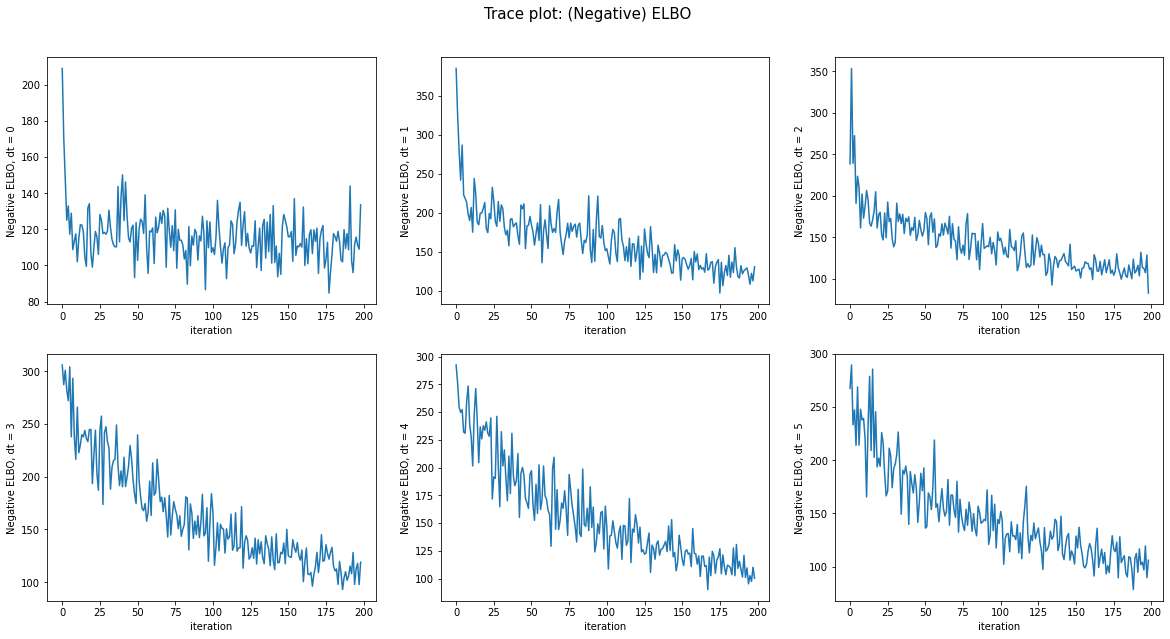

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
t = 0
for ax in ax.ravel():
    ax.plot(np.arange(len(elbo_traces[t, :])), elbo_traces[t, :])
    ax.set_xlabel("iteration")
    ax.set_ylabel("Negative ELBO, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: (Negative) ELBO", size=15, y=0.95)
plt.show()

Trace plot: KL divergence

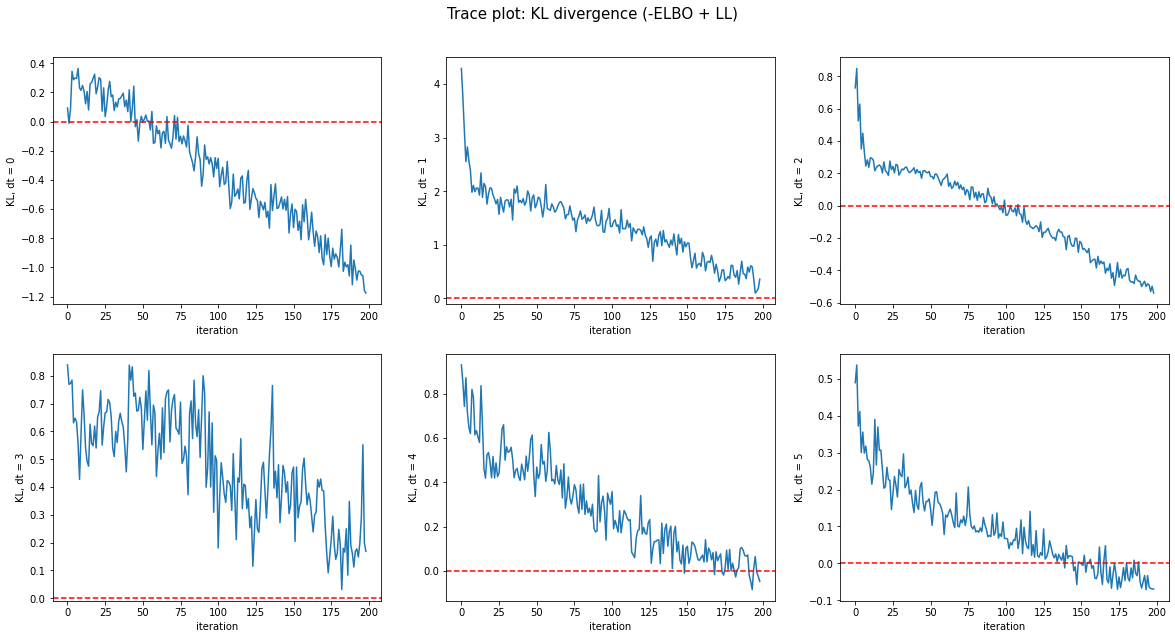

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
t = 0
for ax in ax.ravel():
    ax.plot(np.arange(len(KL_traces[t, :])), -1 * KL_traces[t, :])
    ax.set_xlabel("iteration")
    ax.set_ylabel("KL, dt = %d" % t)
    ax.axhline(0, color='red', linestyle='dashed')
    t += 1
    
plt.suptitle("Trace plot: KL divergence (-ELBO + LL)", size=15, y=0.95)
plt.show()

Trace plot: NLL

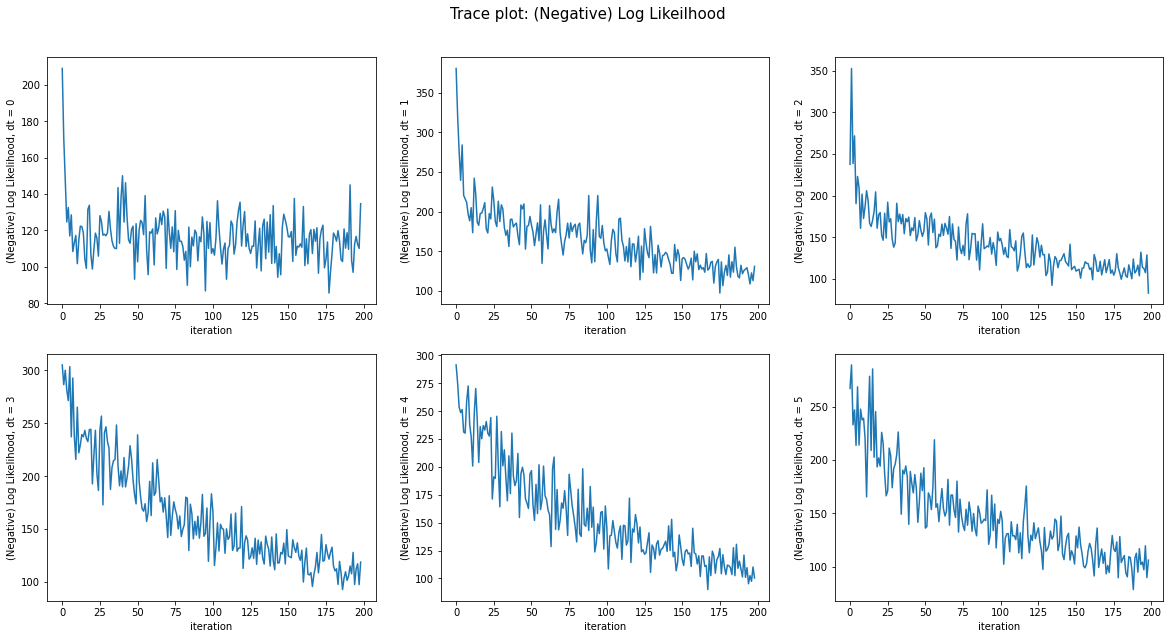

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
t = 0
for ax in ax.ravel():
    ax.plot(np.arange(len(NLL_traces[t, :])), -1 * NLL_traces[t, :])
    ax.set_xlabel("iteration")
    ax.set_ylabel("(Negative) Log Likelihood, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: (Negative) Log Likeilhood", size=15, y=0.95)
plt.show()

Trace plot: parameters

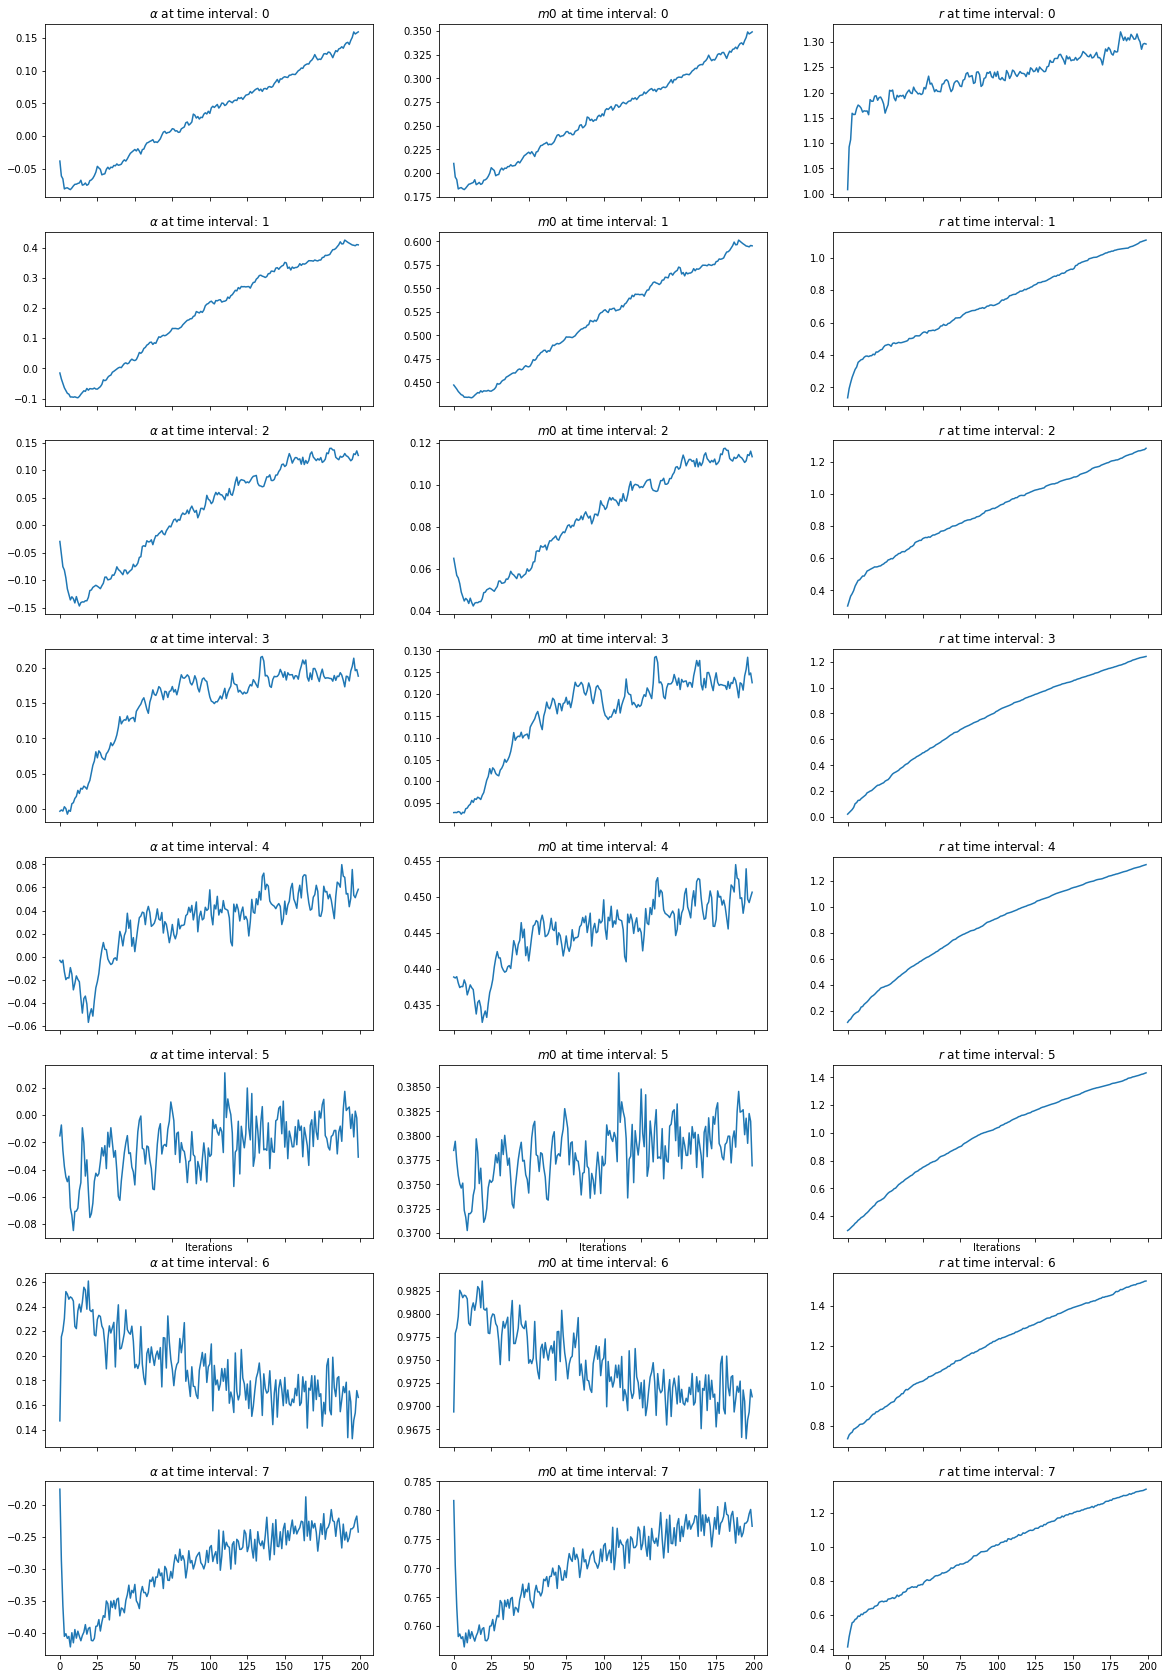

In [15]:
fig, ax = plt.subplots(nrows=pars_traces.shape[1], ncols=3, figsize=(20, 30), sharex='all')
names = [r'$\alpha$', r'$m0$', r'$r$']
for j, ax in enumerate(ax.ravel()):
    i = j % 3
    t = j // 3
    ax.plot(np.arange(pars_traces[i, t, :].shape[0]), pars_traces[i, t, :])
    ax.set_title(names[i] + " at time interval: %d" % t)
#     ax.set_yticks(np.linspace(0,2,10))
    if t == 5:
        ax.set_xlabel("Iterations")
plt.show()

**Posterior approximation**

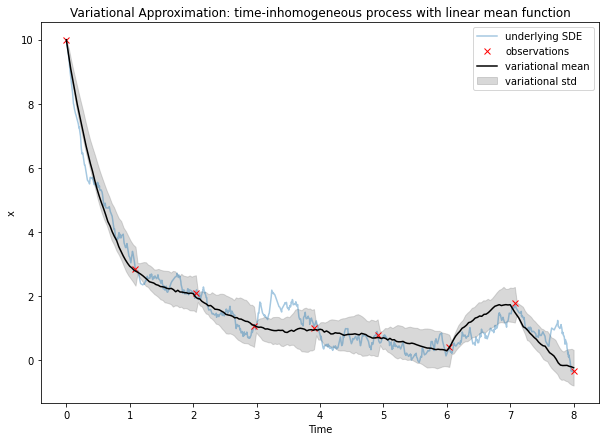

In [16]:
vi_mean = np.concatenate(vp_mean)
vi_var = np.concatenate(vp_std)
vi_pts = np.concatenate(vp_pts)

plt.figure(figsize=(10, 7))
plt.plot(true_sde.pts.T, true_sde.trj.T, label="underlying SDE", alpha=0.4)
plt.plot(obs_time, obs, 'rx', label='observations')
plt.plot(np.linspace(true_sde.pts[0], true_sde.pts[-1], vi_mean.shape[0]), vi_mean, color='black', label='variational mean')
plt.fill_between(vi_pts, vi_mean + vi_var, vi_mean - vi_var, alpha=0.3, color='grey', label='variational std')
plt.legend()
plt.xlabel("Time")
plt.ylabel("x")
plt.title("Variational Approximation: time-inhomogeneous process with linear mean function")
plt.show()

In [ ]:
import pickle

In [ ]:
with open('EX02_OU', 'wb') as f:
    pickle.dump(true_sde, f)
    pickle.dump(obs, f)
    pickle.dump(obs_time, f)
    pickle.dump(obs_sigma, f)
    pickle.dump(sde_sigma, f)